In [1]:
from keras import backend as K
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization
from keras.layers import Activation, MaxPooling2D, Flatten, Dense
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import pydot
from tqdm import tqdm

%matplotlib inline
%config IPCompleter.greedy=True

Using TensorFlow backend.


### Load Data

In [66]:
(X_train_new, y_train_new), (X_test_new, y_test_new) = mnist.load_data()

This is the number 2


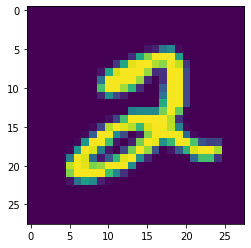

In [67]:
index = 5
plt.imshow(X_train_new[index])
print("This is the number " + str(y_train_new[index]))

### Data Preprocessing

In [68]:
#Slice array to train to smaller chunks if needed
train_slice = 60000
test_slice = 10000

X_train = X_train_new[:train_slice]
y_train = y_train_new[:train_slice]
X_test = X_test_new[:test_slice]
y_test = y_test_new[:test_slice]

#Reshape to format suitable for model
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
input_shape = (28, 28, 1)

#Normalize Inputs
X_train /= 255
X_test /= 255

#Apply one-hot to output y
y_train = tf.Session().run(K.one_hot(y_train, 10))
y_test = tf.Session().run(K.one_hot(y_test, 10))

print("The Shape of X_train is: " + str(X_train.shape))
print("The Shape of y_train is: " + str(y_train.shape))
print("The Shape of X_test is: " + str(X_test.shape))
print("The Shape of y_test is: " + str(y_test.shape))

The Shape of X_train is: (60000, 28, 28, 1)
The Shape of y_train is: (60000, 10)
The Shape of X_test is: (10000, 28, 28, 1)
The Shape of y_test is: (10000, 10)


### Build Model: 3-layer CNN with Batch Norm and Max Pooling + 2 Dense Layers

In [69]:
X_input = Input(input_shape)

In [70]:
X = ZeroPadding2D((3,3))(X_input)

#Layer 1
X = Conv2D(32, (5,5), strides = (1,1), name = 'conv1', padding = 'same')(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((2,2), padding = 'same')(X)
print(X.shape)

#Layer 2
X = Conv2D(64, (3,3), strides = (1,1), name = 'conv2', padding = 'same')(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((2,2), padding = 'same')(X)
print(X.shape)

#Layer 2
X = Conv2D(128, (3,3), strides = (1,1), name = 'conv3', padding = 'same')(X)
X = BatchNormalization(axis = 3)(X)
X = Activation('relu')(X)
X = MaxPooling2D((2,2), padding = 'same')(X)
print(X.shape)

#Fully Connected
X = Flatten()(X)
print(X.shape)
X = Dense(256, activation = 'relu', name = 'fc1')(X)
print(X.shape)
X = Dense(10, activation = 'softmax', name = 'fc2')(X)
print(X.shape)

(?, 17, 17, 32)
(?, 9, 9, 64)
(?, 5, 5, 128)
(?, ?)
(?, 256)
(?, 10)


In [71]:
#Call the functional model API
model = Model(inputs = X_input, outputs = X, name = 'HandwrittenRecog')

In [72]:
#Compile model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ["accuracy"])

### Model Training

In [73]:
#Train the model
model.fit(X_train, y_train, epochs = 20, batch_size = 128, validation_split = 0.2, shuffle=True)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 11s 220us/step - loss: 0.2085 - acc: 0.9442 - val_loss: 0.1168 - val_acc: 0.9648
Epoch 2/20
48000/48000 [==============================] - 10s 199us/step - loss: 0.0475 - acc: 0.9848 - val_loss: 0.0623 - val_acc: 0.9819
Epoch 3/20
48000/48000 [==============================] - 10s 200us/step - loss: 0.0327 - acc: 0.9899 - val_loss: 0.0380 - val_acc: 0.9887
Epoch 4/20
48000/48000 [==============================] - 10s 202us/step - loss: 0.0272 - acc: 0.9910 - val_loss: 0.0413 - val_acc: 0.9867
Epoch 5/20
48000/48000 [==============================] - 10s 201us/step - loss: 0.0233 - acc: 0.9923 - val_loss: 0.1155 - val_acc: 0.9690
Epoch 6/20
48000/48000 [==============================] - 10s 201us/step - loss: 0.0185 - acc: 0.9939 - val_loss: 0.3095 - val_acc: 0.9239
Epoch 7/20
48000/48000 [==============================] - 10s 200us/step - loss: 0.0169 - acc: 0.9939 - val_loss: 0.

### Model Evaluation

In [58]:
predictions = model.evaluate(X_test, y_test)
print()
print("Loss = " + str(round(predictions[0], 4)))
print("Test Accuracy = " + str (round(predictions[1] * 100, 2)) + "%")

10000/10000 [==============================] - 1s 112us/step

Loss = 0.0111
Test Accuracy = 99.68%


Predicted Class: 9


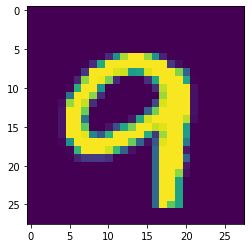

In [59]:
#Test Predictions
test_index = 501
pred = np.argmax(model.predict(X_test[test_index:test_index+1]))
plt.imshow(np.squeeze(X_test[test_index]))
print("Predicted Class: " + str(pred))

### Model Summary

In [22]:
#Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 34, 34, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 34, 34, 16)        416       
_________________________________________________________________
batch_normalization_7 (Batch (None, 34, 34, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 34, 34, 16)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 17, 32)        12832     
__________

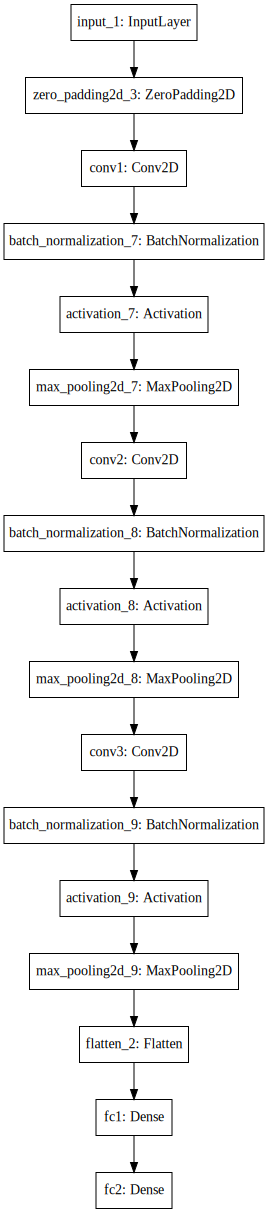

In [23]:
#Model Plot
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

plot_model(model, to_file='HandwrittenRecog.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Kaggle Submission

In [60]:
#Import Kaggle Test Data
data_kg = np.array(pd.read_csv("test.csv"))
data_kg.shape

(28000, 784)

In [61]:
data_kg_reshape = data_kg.reshape(data_kg.shape[0], 28, 28, 1)
data_kg_reshape.shape

(28000, 28, 28, 1)

Predicted Class: 3


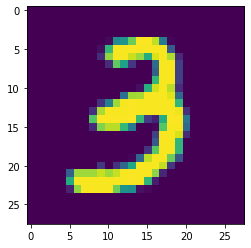

In [62]:
#Test Predictions
index_kg = 7
kg_pred = np.argmax(model.predict(data_kg_reshape[index_kg:index_kg+1]))
plt.imshow(np.squeeze(data_kg_reshape[index_kg]))
print("Predicted Class: " + str(kg_pred))

In [63]:
#Make predictions

results = []

for index in tqdm(range(data_kg_reshape.shape[0])):
    prediction = np.argmax(model.predict(data_kg_reshape[index:index+1]))
    results.append((index+1, prediction))

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [00:39<00:00, 717.83it/s]


In [64]:
#Save predictions on a .csv format
results_array = np.array(results)
np.savetxt("kaggle_mnist.csv", results_array, fmt='%d', delimiter=",")